### Importancia de la Normalización de las características para el algoritmo K-Neighbors

En este ejercicio vamos a ver que es crítico el uso de componentes normalizadas en conjuntos de datos donde los rangos de valores son muy diferentes entre características. 

Consideremos la tabla 'ventas.csv' que indica si hemos conseguido vender un seguro de vida a diferentes potenciales clientes de los cuales sabemos su sueldo y su edad. 

La idea es hacer un predictor al que introduciéndole el sueldo y la edad del potencial cliente nos indique si es probable que nos compre el seguro de vida. Para ello vamos a utilizar el algoritmo de los K-vecinos. Específicamente vamos a buscar el vecino más próximo al dato de consulta y asumiremos que el comportamiento previsto será el de dicho vecino.

In [2]:
#cargamos el dataset de los clientes que conocemos en un DataFrame.Llámalo 'data'

import pandas as pd
import numpy as np

#Código aquí
data = pd.read_csv('ventas.csv', sep = ';')
print(data)



   Sueldo  Edad Compra
0   53700    41     no
1   65300    37     no
2   48900    45     si
3   64800    49     si
4   44200    30     no
5   55900    57     si
6   48600    26     no
7   72800    60     si
8   45300    34     no
9   73200    52     si


In [3]:
#Del original separamos las columnnas que harán de puntos en un espacio 2D 'Sueldo' y 'Edad'  
#y dejamos en otro dataframe la columna 'Compra' que es la respuesta a la consulta

gt = data.drop(['Sueldo', 'Edad' ], axis=1)
Y = data.drop(['Compra'], axis=1)

#Las transformamos en arrays
Ynp = Y.to_numpy()

gtnp = gt.to_numpy()

In [11]:
#cargamos el algoritmo de K-Neighbors
from sklearn.neighbors import KNeighborsClassifier

#preparamos el clasificador para devolver el primer vecino mas próximo. Lo llamamos 'neigh'

#Código aquí
neigh = KNeighborsClassifier()
#Introducimos el dataset para que realice el aprendizaje
neigh.fit(Ynp, np.ravel(gtnp))

KNeighborsClassifier()

Observa en el diagrama que se genera en la siguiente casilla la disposición de los puntos del dataset. Hemos puesto con 'x' 
los puntos que marcan clientes que no han comprado el seguro y con triángulos los clientes que sí lo han comprado.

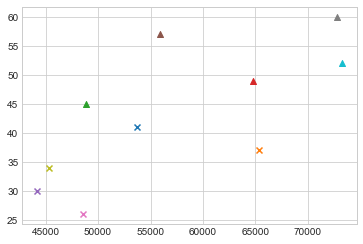

In [47]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#Definimos los símbolos que representamos en el diagrama
marker=['x','^']

#Vamos a codificar de manera binaria los valores 'si' 'no' de la tabla de respuestas 'Compra'
#para utilizarlos como índice en el array 'marker'. Así, los que no compran se visualizarán como puntos
#en forma de aspa y los que compran se visualizarán como triángulos.
import category_encoders as ce
encoder = ce.BinaryEncoder()

#Código aquí. codifica el array gtnp
gtnpq = encoder.fit_transform(gtnp)["0_0"]

pp=np.array(gtnpq)
#Código aquí. Visualiza con plt.scatter el dataset  Ynp utilizando 'marker' con la información de pp
for i in range(len(Ynp)):
    if pp[i] == 0:
        plt.scatter(Ynp[i][0],Ynp[i][1],marker=marker[0])
    else:
        plt.scatter(Ynp[i][0],Ynp[i][1],marker=marker[1])


Visualizando la gráfica podemos hacernos una idea de cuál es el perfil del cliente que NO va a comprar un seguro.
Especifica ese perfil. 

**Respuesta:**
Se puede observar en la gráfica que es indiferente el sueldo. Se pueden diferencias dos grupos: mayores de 40 (compran seguros) y menor de 40 (no compran seguros).

Vamos a predecir si un cliente que cobra 56000 euros al año y tiene 35 años nos compraría el seguro o no. 
Para ello buscaremos el vecino más próximo y consultaremos la decisión que tomó ese vecino.

In [48]:
dist, index = neigh.kneighbors(np.array([56000 , 35]).reshape(1,-1),1,True)

print(dist)
print(index)

print("Vecino mas proximo")
print(data.iloc[index[0,0]])

[[102.39140589]]
[[5]]
Vecino mas proximo
Sueldo    55900
Edad         57
Compra       si
Name: 5, dtype: object


Vemos que el que nos ha dado como vecino más próximo, no parece cumplir el perfil del dato de consulta.
Si visualizamos el punto del potencial cliente buscado, no *'parece'* estar cercano al vecino más próximo en la gráfica:

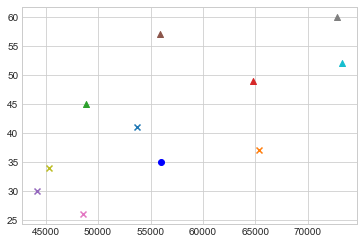

In [49]:
#Código aquí. Visualiza con plt.scatter el dataset  Ynp utilizando 'marker' con la información de pp
for i in range(len(Ynp)):
    if pp[i] == 0:
        plt.scatter(Ynp[i][0],Ynp[i][1],marker=marker[0])
    else:
        plt.scatter(Ynp[i][0],Ynp[i][1],marker=marker[1])

#pintamos el punto de query
plt.scatter(56000,35,marker='o', color='blue')

Explica con tus palabras a qué se debe este resultado.

**Respuesta:**
Observamos que el centroide está teniendo encuenta solo el sueldo y descartando la edad. Por lo tanto, el criterio de agrupación es incorrecto.

Vamos a normalizar las características del array Ynp para que ambas se encuentren en el mismo rango. Para ello vamos a usar el método 
MinMaxScaler de sklearn.preprocessing

In [51]:
from sklearn.preprocessing import MinMaxScaler

#Código aquí.
scaler = MinMaxScaler()

scaler.fit(Ynp)
Ynpnorm = scaler.transform(Ynp)

#observa ahora cómo los valores están normalizados
print(Ynpnorm)

#Llama ahora otra vez al clasificador de k-vecinos para un solo vecino
neigh2 = KNeighborsClassifier(n_neighbors=1)
neigh2.fit(Ynpnorm, np.ravel(gtnp))

#Obtén con scaler las características normalizadas del punto (56000,35)
query = scaler.transform([[56000,35]])

#Obtén ahora con el clasificador neigh2 el vecino más próximo de query
dist2, index2 = neigh2.kneighbors(np.array(query).reshape(1,-1),1,True)

[[0.32758621 0.44117647]
 [0.72758621 0.32352941]
 [0.16206897 0.55882353]
 [0.71034483 0.67647059]
 [0.         0.11764706]
 [0.40344828 0.91176471]
 [0.15172414 0.        ]
 [0.9862069  1.        ]
 [0.03793103 0.23529412]
 [1.         0.76470588]]


In [55]:
#imprimimos el nuevo resultado
print("Vecino mas proximo")
print(data.iloc[index2[0,0]])

Vecino mas proximo
Sueldo    53700
Edad         41
Compra       no
Name: 0, dtype: object


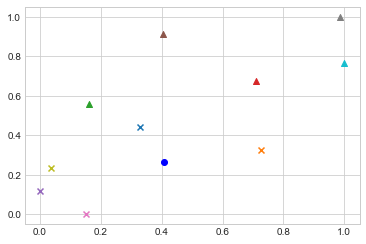

In [53]:
#Código aquí. Visualiza con plt.scatter el dataset normalizado
for i in range(len(Ynpnorm)):
    if pp[i] == 0:
        plt.scatter(Ynpnorm[i][0],Ynpnorm[i][1],marker=marker[0])
    else:
        plt.scatter(Ynpnorm[i][0],Ynpnorm[i][1],marker=marker[1])
        
plt.scatter(query[:,0],query[:,1],marker='o', color='blue')

Observa la gráfica y explica el resultado que has obtenido con el nuevo dato normalizado 'query'.

**Respuesta:**
Una vez normalizados los datos, se observa que el vecino tiene una edad similar y, dado que esto es el valor más representativo, le da coherencia a la búsqueda del vecino.